# Modelagem e criação de modelos de classificação com machine learning para algoritmos de tradding

Gabriel Ghellere 2019

## Workflow  

Baseado do livro Machine Learning Hands On

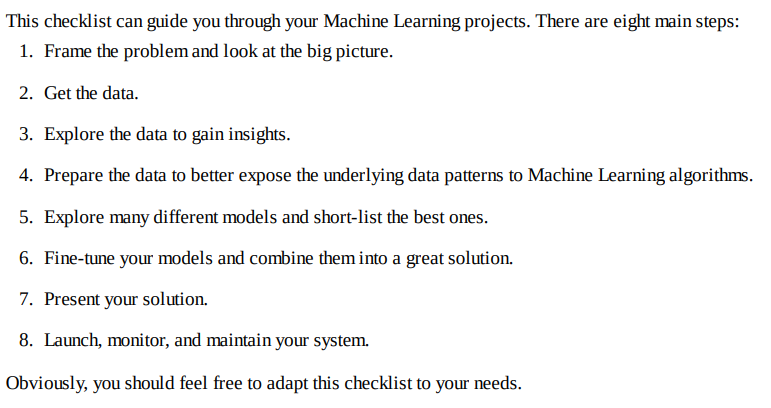

### 1 Frame the problem and look at the big picture

Já sabemos que algoritmos de Machine Learning são válidos para a criação de estratégias para trader bots então agora nossa decisão é qual abortagem que iremos utilizar para a resolver o problema. 

Existem inúmeras opções de algoritmos e técnicas para aplicar algoritmos de Machine Learning para trade. Pode-se usar técnicas de predição com redes neurais (LSTM OU CNN) ou usar aprendizado por reforço, mas nesse caso vamos modelar para utilizar um algoritmo de classificação.

### 2 Get The data

A aquisição dos dados é feita através do wrapper para a REST API da Binance. Os dados são basicamente o preço do ativo no formato OHLCV (Open, High, Low, Close e Volume), em seguida se faz o parse para um dataframe do Pandas.

In [1]:
import requests, json
from binance.client import Client
from binance.enums import *

import pandas as pd
import numpy as np
import time
from datetime import datetime

from math import pi
import bokeh
bokeh.sampledata.download()
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.sampledata.stocks import MSFT

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


class Aquisition(object):
    
    
    def __init__(self):
        self.client = Client('', '')
        self.df = pd.DataFrame(columns= ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time'])
           
    def cast_to_dataframe(self, opentime, lopen, lhigh, llow, lclose, lvol, closetime):
        self.df['Open_time'] = opentime
        self.df["date"] = opentime
        self.df['Open'] = np.array(lopen).astype(np.float)
        self.df['High'] = np.array(lhigh).astype(np.float)
        self.df['Low'] = np.array(llow).astype(np.float)
        self.df['Close'] = np.array(lclose).astype(np.float)
        self.df['Volume'] = np.array(lvol).astype(np.float)
        self.df['Close_time'] = closetime
        self.df["date"] = pd.to_datetime(self.df['date'],unit='ms')
        
    def parse(self, candles):   
        opentime, lopen, lhigh, llow, lclose, lvol, closetime = [], [], [], [], [], [], []
        for candle in candles:
            opentime.append(candle[0])
            lopen.append(candle[1])
            lhigh.append(candle[2])
            llow.append(candle[3])
            lclose.append(candle[4])
            lvol.append(candle[5])
            closetime.append(candle[6])    
        self.cast_to_dataframe(opentime, lopen, lhigh, llow, lclose, lvol, closetime)
        
    def get_candles(self):
        #candles = self.client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "1 Ago, 2018")
        candles = self.client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1DAY)
        self.parse(candles)
        return self.df
    
    def get_price_now(self):
        r = requests.get("https://www.binance.com/api/v3/ticker/price?symbol=BTCUSDT")
        r = r.content
        jsonResponse = json.loads(r.decode('utf-8'))
        return float(jsonResponse['price'])
    
    
    def plot_candles(self):
        df = self.df[450:]
        df["date"] = df["Open_time"]
        df["date"] = pd.to_datetime(self.df['date'],unit='ms')
        inc = df.Close > df.Open
        dec = df.Open > df.Close
        w = 12*60*60*1000 # half day in ms
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "BITCOIN Candlestick")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3
        p.segment(df.date, df.High, df.date, df.Low, color="black")
        p.vbar(df.date[inc], w, df.Open[inc], df.Close[inc], fill_color="#006400", line_color="black")
        p.vbar(df.date[dec], w, df.Open[dec], df.Close[dec], fill_color="#F2583E", line_color="black")
        output_notebook()
        return p 

Creating /home/devel/.bokeh directory
Creating /home/devel/.bokeh/data directory
Using data directory: /home/devel/.bokeh/data
Downloading: CGM.csv (1589982 bytes)
   1589982 [100.00%]
Downloading: US_Counties.zip (3182088 bytes)
   3182088 [100.00%]
Unpacking: US_Counties.csv
Downloading: us_cities.json (713565 bytes)
    713565 [100.00%]
Downloading: unemployment09.csv (253301 bytes)
    253301 [100.00%]
Downloading: AAPL.csv (166698 bytes)
    166698 [100.00%]
Downloading: FB.csv (9706 bytes)
      9706 [100.00%]
Downloading: GOOG.csv (113894 bytes)
    113894 [100.00%]
Downloading: IBM.csv (165625 bytes)
    165625 [100.00%]
Downloading: MSFT.csv (161614 bytes)
    161614 [100.00%]
Downloading: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.zip (5148539 bytes)
   5148539 [100.00%]
Unpacking: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.csv
Downloading: gapminder_fertility.csv (64346 bytes)
     64346 [100.00%]
Downloading: gapminder_population.csv (94509 bytes)
     94509 [100.00%]
Downloading

O dataframe resultante pode ser visto abaixo:

In [2]:
candles = Aquisition()
dataframe = candles.get_candles()
dataframe.head()

,Open_time,Open,High,Low,Close,Volume,Close_time,date
0,1508457600000,5683.31,6110.0,5600.00,6010.01,1972.977220,1508543999999,2017-10-20
1,1508544000000,6013.72,6171.0,5850.03,6024.97,1664.307693,1508630399999,2017-10-21
2,1508630400000,6003.27,6060.0,5720.03,5950.02,1362.092216,1508716799999,2017-10-22
3,1508716800000,5975.00,6080.0,5621.03,5915.93,1812.557715,1508803199999,2017-10-23
4,1508803200000,5909.47,5925.0,5450.00,5477.03,2580.418767,1508889599999,2017-10-24


### 3 Explore the data to gain insigts

Agora é necessário ter um entendimento melhor do problema, então em seguida faremos algumas análises em nossos dados para tentar obter algum insight  interessante.

In [3]:
dataframe.shape

(500, 8)

Então plota-se com o bokeh os candles com um stock chart no formato OHLCV

In [4]:
plot = candles.plot_candles()
show(plot)

Loading BokehJS ...

### Interpretando um candle:

#### Os 3 elementos dos Candlesticks

#### 1. Período

O principal conceito dos candlesticks é que cada candle representa o que ocorreu com o preço de uma ação durante um determinado período de tempo. Cada candle pode representar 1 minuto, 5 minutos, 1 hora, 1 semana, 1 mês e até mesmo 1 ano. Você é que escolhe.

#### 2. Formato
O formato do candle por sua vez é determinado por importantes valores que o preço da ação atingiu durante este determinado período. São os preço de:

+abertura
+fechamento
+mínimo
+máximo

Estes valores dão forma aos dois elementos que compõem um Candle:

o corpo (que traz as informações de fechamento e abertura), e
a sombra (que informa os máximos e mínimos do período).

#### 3. Cor
O terceiro elemento que compõem um candlestick é a sua cor, isso determina se o candlestick é de alta ou de baixa.

Quando o preço de fechamento está abaixo do preço de abertura, significa que o preço da ação caiu durante aquele determinado período e o Candle será de baixa.

Quando o preço de fechamento for maior que o preço de abertura, significa que o preço subiu durante aquele período e o candlestick será de alta.

Veja na figura abaixo como interpretar cada um dos três elementos do candlestick:

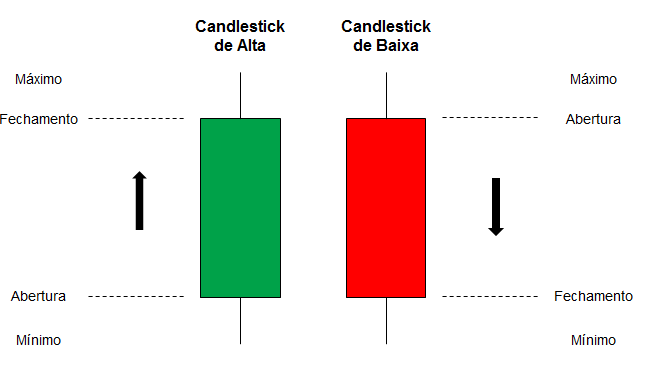

### Somente Candles não são o suficiente

Infelizmente apesar dos candles nos dizerem muito sobre o ativo, ainda não são dados suficientes para rodar nos algoritmos. Para isso calculam-se alguns indicadores de mercado. Indicadores de mercado são métodos práticos para obter estimativas sobre o valor da empresa, então são amplamente utilizados por traders para a comparação entre ações facilitando, ou não, na tomada de decisão.

### Calculando indicadores



Existem muitos indicadores famosos e a maioria é explicita por fórmulas matemáticas com base em estatística. Um exemplo são as famosas Bandas de Boillinger.

Análise de Bollinger (também conhecida como Bandas de Bollinger) são ferramentas de análise técnica criadas por John Bollinger no início dos anos 80. Este indicador possui uma forte relação com a volatilidade, possibilitando, assim, a sua comparação com os níveis de preços num determinado período de tempo. O maior objetivo das bandas Bollinger é fornecer uma ideia relativa de alto e baixo. Por definição, os preços são altos na linha (banda) superior e baixos na linha (banda) inferior.

O indicador é calculado pela seguinte fórmula: 

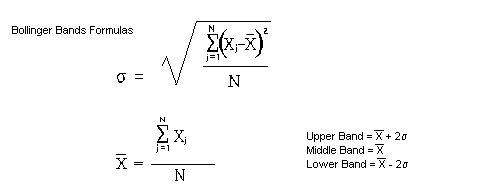

***Vamos a implementação:*** 

In [5]:
class Bbands(Aquisition):  
    
    
    def __init__(self, nDer = 2, period = 20):
        super(Bbands, self).__init__()
        self.candles = super().get_candles()
        self.nDer = nDer
        self.period = period
    
    def eval_boillinger_bands(self):
        self.candles['30 Day MA'] = self.candles['Close'].rolling(window=self.period).mean()
        self.candles['30 Day STD'] = self.candles['Close'].rolling(window=self.period).std()
        self.candles['Upper Band'] = self.candles['30 Day MA'] + (self.candles['30 Day STD'] * self.nDer)
        self.candles['Lower Band'] = self.candles['30 Day MA'] - (self.candles['30 Day STD'] * self.nDer)
        
    def configure_plot(self, df):
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Bbands Chart")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3
        p.line(df.date, df.Close, line_color="black")
        p.line(df.date, df['30 Day MA'], line_color="red", legend="30 Day MA", muted_alpha=0.2)
        p.line(df.date, df['Upper Band'], line_color="blue", legend="Upper Band", muted_alpha=0.2)
        p.line(df.date, df['Lower Band'], line_color="green", legend="Lower Band", muted_alpha=0.2)
        
        p.legend.location = "top_left"
        p.legend.click_policy="mute"
        return p
        
    def plot_bands(self):
        df = self.candles
        p = self.configure_plot(df)
        output_notebook()
        return p  
        
    def plot_cross_points(self):
        self.eval_boillinger_bands()
        
        self.candles['up_cross'] = np.where((self.candles['Close'] >= self.candles['Upper Band'])
                                            , self.candles['Close'], None)       
        self.candles['down_cross'] = np.where((self.candles['Close'] <= self.candles['Lower Band'])
                                              , self.candles['Close'], None)
        
        p = self.configure_plot(self.candles)        
        p.circle(self.candles.date, self.candles['up_cross'], size=5, color="red", alpha=1, legend="Up cross")
        p.circle(self.candles.date, self.candles['down_cross'], size=5, color="green", alpha=1,legend="Down cross")   
        output_notebook()
        return p 
        
    def detect_cross(self):
        self.eval_boillinger_bands()   
        self.candles['up_cross'] = np.where((self.candles['Close'] >= self.candles['Upper Band']) , 1, 0)
        self.candles['down_cross'] = np.where((self.candles['Close'] <= self.candles['Lower Band']) , 1,  0)

### Visualização das bandas:

Pode-se visualizar as bandas calculadas para uma melhor interpretação

In [6]:
bands = Bbands()
bands.eval_boillinger_bands()
plot = bands.plot_bands()
show(plot)

Loading BokehJS ...

#  Cross

Outro ponto importante é a possibilidade de adicionar uma interpretação das bandas extraindo mais um sinal delas. São os pontos de cruzamento da linha do fechamento (close) com as bandas superiores e inferiores. 

In [7]:
bands.plot_cross_points()

Loading BokehJS ...

bokeh.plotting.figure.Figure(
    id='b0363a3a-0a0e-441d-aa72-82710c3ec491',
    above=[],
    aspect_scale=1,
    background_fill_alpha={'value': 1.0},
    background_fill_color={'value': '#ffffff'},
    below=[bokeh.models.axes.DatetimeAxis(
         id='ebe19eb7-52e0-47a5-86d6-e3c4a0313799',
         axis_label='',
         axis_label_standoff=5,
         axis_label_text_align='left',
         axis_label_text_alpha={'value': 1.0},
         axis_label_text_baseline='bottom',
         axis_label_text_color={'value': '#444444'},
         axis_label_text_font='helvetica',
         axis_label_text_font_size={'value': '10pt'},
         axis_label_text_font_style='italic',
         axis_label_text_line_height=1.2,
         axis_line_alpha={'value': 1.0},
         axis_line_cap='butt',
         axis_line_color={'value': 'black'},
         axis_line_dash=[],
         axis_line_dash_offset=0,
         axis_line_join='miter',
         axis_line_width={'value': 1},
         bounds='auto',
         fixed_location=None,
         formatter=bokeh.models.formatters.DatetimeTickFormatter(
             id='e25af082-486d-4e59-b3e8-2a6375813d8a',
             days=['%m/%d', '%a%d'],
             hourmin=['%H:%M'],
             hours=['%Hh', '%H:%M'],
             js_event_callbacks={},
             js_property_callbacks={},
             microseconds=['%fus'],
             milliseconds=['%3Nms', '%S.%3Ns'],
             minsec=[':%M:%S'],
             minutes=[':%M', '%Mm'],
             months=['%m/%Y', '%b %Y'],
             name=None,
             seconds=['%Ss'],
             subscribed_events=[],
             tags=[],
             years=['%Y']),
         js_event_callbacks={},
         js_property_callbacks={},
         level='overlay',
         major_label_orientation=0.7853981633974483,
         major_label_overrides={},
         major_label_standoff=5,
         major_label_text_align='center',
         major_label_text_alpha={'value': 1.0},
         major_label_text_baseline='alphabetic',
         major_label_text_color={'value': '#444444'},
         major_label_text_font='helvetica',
         major_label_text_font_size={'value': '8pt'},
         major_label_text_font_style='normal',
         major_label_text_line_height=1.2,
         major_tick_in=2,
         major_tick_line_alpha={'value': 1.0},
         major_tick_line_cap='butt',
         major_tick_line_color={'value': 'black'},
         major_tick_line_dash=[],
         major_tick_line_dash_offset=0,
         major_tick_line_join='miter',
         major_tick_line_width={'value': 1},
         major_tick_out=6,
         minor_tick_in=0,
         minor_tick_line_alpha={'value': 1.0},
         minor_tick_line_cap='butt',
         minor_tick_line_color={'value': 'black'},
         minor_tick_line_dash=[],
         minor_tick_line_dash_offset=0,
         minor_tick_line_join='miter',
         minor_tick_line_width={'value': 1},
         minor_tick_out=4,
         name=None,
         plot=bokeh.plotting.figure.Figure(id='b0363a3a-0a0e-441d-aa72-82710c3ec491', ...),
         subscribed_events=[],
         tags=[],
         ticker=bokeh.models.tickers.DatetimeTicker(
             id='3143bd14-4af3-4c2b-a0c8-fbbac9fe742f',
             desired_num_ticks=6,
             js_event_callbacks={},
             js_property_callbacks={},
             name=None,
             num_minor_ticks=5,
             subscribed_events=[],
             tags=[],
             tickers=[bokeh.models.tickers.AdaptiveTicker(
                  id='b6a6012d-cf79-45c2-bfc7-b6f5eb58f31b',
                  base=10.0,
                  desired_num_ticks=6,
                  js_event_callbacks={},
                  js_property_callbacks={},
                  mantissas=[1, 2, 5],
                  max_interval=500.0,
                  min_interval=0.0,
                  name=None,
                  num_minor_ticks=0,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tickers.Adapti

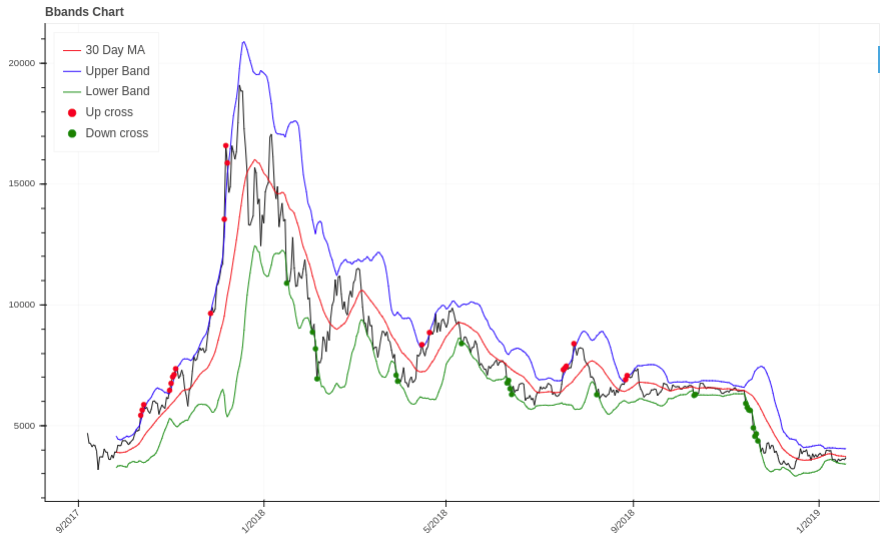

Adicionando todos esse indicadores nosso dataframe fica o seguinte:

In [8]:
bands.detect_cross()
bands.df.head()

,Open_time,Open,High,Low,Close,Volume,Close_time,date,30 Day MA,30 Day STD,Upper Band,Lower Band,up_cross,down_cross
0,1508457600000,5683.31,6110.0,5600.00,6010.01,1972.977220,1508543999999,2017-10-20,NaN,NaN,NaN,NaN,0,0
1,1508544000000,6013.72,6171.0,5850.03,6024.97,1664.307693,1508630399999,2017-10-21,NaN,NaN,NaN,NaN,0,0
2,1508630400000,6003.27,6060.0,5720.03,5950.02,1362.092216,1508716799999,2017-10-22,NaN,NaN,NaN,NaN,0,0
3,1508716800000,5975.00,6080.0,5621.03,5915.93,1812.557715,1508803199999,2017-10-23,NaN,NaN,NaN,NaN,0,0
4,1508803200000,5909.47,5925.0,5450.00,5477.03,2580.418767,1508889599999,2017-10-24,NaN,NaN,NaN,NaN,0,0


Agora além dos indicadores do gráfico OHLCV ainda temos uma média móvel, o desfio padrão o valor das Bandas de Boillinger e o cruzamento das mesmas. Observe que poluimos o dataframe com campos de data missing (NaN) e esses pontos se encontram nos candles iniciais antes de existirem pontos suficientes para calcular as médias móveis.

## Adicionando mais indicadores

Agora que sabemos o que são indicadores e como implementa-los vamos ao modo mais fácil adicionando mais alguns usando a biblioteca pyti



In [9]:
from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.aroon import aroon_down, aroon_up
from pyti.ichimoku_cloud import tenkansen, kijunsen, chiku_span, senkou_a, senkou_b
from pyti.momentum import momentum

class Indicators():
    def __init__(self, candles):
        self.candles = candles
    
    def add_indicators(self):
        self.candles = self.candles.drop(['Open_time', 'Close_time'], axis=1)
        self.candles['EMA - 15'] = ema(self.candles['Close'].tolist(), 15)
        self.candles['aaron down'] = aroon_down(self.candles['Close'].tolist(), 25)
        self.candles['aaron up'] = aroon_up(self.candles['Close'].tolist(), 25)
        self.candles['tenkansen'] = tenkansen(self.candles['Close'].tolist())
        self.candles['kijunsen'] = kijunsen(self.candles['Close'].tolist())
        self.candles['momentun'] = momentum(self.candles['Close'], 15)
        return self.candles

Os indicadores escolhidos (arbitrariamente) foram:

+ Media móvel esponencial de 15 valores
+ arron up e down
+ Nuvens de ichimoku (tenkasen, kijusen)
+ momentun

## DESAFIOS
+ #### Quantos indicadores são o suficiente?
+ #### Quais os melhores indicadores?
+ #### Indicadores realmente conseguem expressar bem a reação do mercado?
+ #### Indicadores com base em análise natural são válidos?
+ #### Pode-se usar a saída de um algoritmo de machine learning como um indicador para outro algoritmo?


#### O dataframe resultante é o seguinte:

In [10]:
idc = Indicators(bands.df)
df = idc.add_indicators()
df.head()

,Open,High,Low,Close,Volume,date,30 Day MA,30 Day STD,Upper Band,Lower Band,up_cross,down_cross,EMA - 15,aaron down,aaron up,tenkansen,kijunsen,momentun
0,5683.31,6110.0,5600.00,6010.01,1972.977220,2017-10-20,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,6013.72,6171.0,5850.03,6024.97,1664.307693,2017-10-21,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,6003.27,6060.0,5720.03,5950.02,1362.092216,2017-10-22,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,5975.00,6080.0,5621.03,5915.93,1812.557715,2017-10-23,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,5909.47,5925.0,5450.00,5477.03,2580.418767,2017-10-24,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### A análise de correlação

Para verificar a correlação entre os indicadores pode-se criar uma matriz com os coeficientes de pearson utilizando o seaborn.

Os coefieientes de pearson são úteis pois mostram a correlação entre duas séries temporais.

Remove-se as colunas High, Low e Open para se observar mais facilmente a correlação entre as variáveis Close e os demais indicadores.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
class Corr(object):
    def __init__(self, df):
        self.df = df
        try:
            self.df = self.df.drop(['High', 'Low', 'Open'], axis=1)
        except:
            pass
    
    def pearson(self):
        plt.figure(figsize=(12,8))
        kwargs = {'fontsize':12,'color':'black'}
        sns.heatmap(self.df.corr(),annot=True,robust=True)
        plt.title('Correlation Analysis',**kwargs)
        plt.tick_params(length=3,labelsize=12,color='black')
        plt.yticks(rotation=0)
        plt.show()

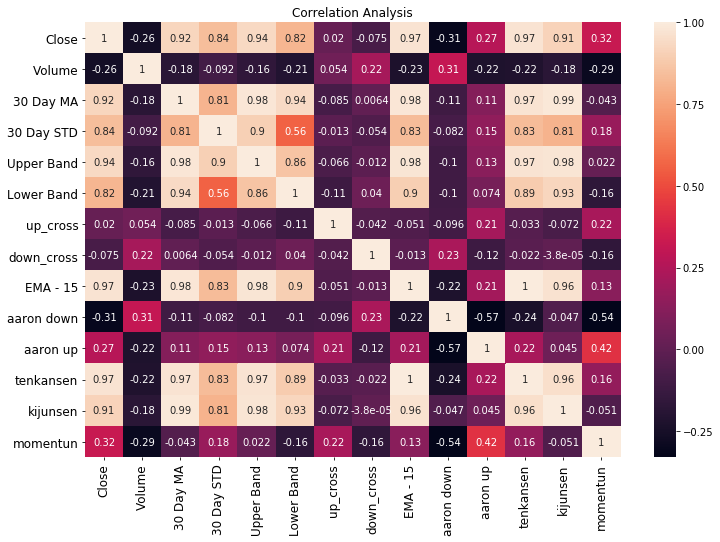

In [12]:
c = Corr(df)
c.pearson()


Como esperado pode-se observar uma alta correlação entre as médias móveis e ichimoku com Close, essa correlação pode servir de base pra criar uma feature selection.

## 4 Prepare the data to better spose the underlying patterns to Machine Learning algorithms


Os algoritmos de machine learning  precisam que os dados estejam preparados para sua execução, veremos melhor a diante. O primeiro passo é definir uma variável target onde o algoritmo usará essa variável nos testes e treinos, também será a variável que as predições são realizadas.

### Criando variável target

Como os indicadores estão calculados o próximo passo é definir uma variável target para o algoritmo classificar.

O método utilizado é look ahead, descrito abaixo:
```
    1 Para cada candle do dataframe
    2 Observe o close do candle atual e do candle atual + 10
    2 Se close < close+10
    3 pinte o candle de verde
    4 Senão pinte o candle de vermelho
```

Assim quando o preço subiu no futuro o candle atual ficará verde indicando um ponto de compra e ao contrário ficará vermelho indicando venda. Essa técnica é relativamente boa pra detectar vales e picos.

In [62]:
class Target(object):
    def __init__(self, candles):
        self.candles = candles
        self.close = self.candles['Close'].tolist() 
        
        
    def test_target(self, shift):
        df['buy'] = df.Close[(df.Close.shift(1) > df.Close) & (df.Close.shift(-1) > df.Close)]
        df['sell'] = df.Close[(df.Close.shift(1) < df.Close) & (df.Close.shift(-1) < df.Close)]
        hold = []
        for idx, value in enumerate(df['Close']):
            if (np.isnan(df['min'][idx]) and np.isnan(df['max'][idx])): #and (df['max'][idx] == np.nan):
                hold.append(value)
            else:
                hold.append(np.nan)
        df['hold'] = hold
        
    def plot_targets(self):   
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Target Chart")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3

        p.line(self.candles.date, self.candles.Close, line_color="black")

        p.circle(self.candles.date, self.candles['sell'], size=5, color="red", alpha=1, legend='buy')
        p.circle(self.candles.date, self.candles['buy'], size=5, color="green", alpha=1, legend='sell')
        p.circle(self.candles.date, self.candles['hold'], size=5, color="blue", alpha=1, legend='sell')


        output_notebook()
        return p

In [63]:
df.head()

,Open,High,Low,Close,Volume,date,30 Day MA,30 Day STD,Upper Band,Lower Band,...,aaron down,aaron up,tenkansen,kijunsen,momentun,buy,sell,min,max,hold
0,5683.31,6110.0,5600.00,6010.01,1972.977220,2017-10-20,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6010.01
1,6013.72,6171.0,5850.03,6024.97,1664.307693,2017-10-21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6024.97,NaN,6024.97,NaN
2,6003.27,6060.0,5720.03,5950.02,1362.092216,2017-10-22,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5950.02
3,5975.00,6080.0,5621.03,5915.93,1812.557715,2017-10-23,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5915.93
4,5909.47,5925.0,5450.00,5477.03,2580.418767,2017-10-24,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5477.03,NaN,5477.03,NaN,NaN


### Visualização do target

O resultado gráfico do look ahead pode ser observado abaixo:

In [64]:
tgt = Target(df)
tgt.test_target(5)
plot = tgt.plot_targets()
show(plot)

Loading BokehJS ...

### Agora que percebemos que essa estratégia de definição do target é razoável adicionamos ao dataframe

Adiciona-se o target ao dataframe:

+ 0- indica um ponto de compra (verde)
+ 1- indica um ponto de venda (vermelho)

In [19]:
def createTarget(candles, shift):
    
    close = candles['Close'].tolist()
    target = []
    
    for i in range (0, len(close)-(shift+1)):
        if float(close[i]) < float(close[i+shift]):
            target.append(0)

        elif float(close[i]) > float(close[i+shift]):
            target.append(1)
            
    if (len(candles.buy) != len(target)):
        len_diff = (len(candles.buy) - len(target))
        for i in range (len(candles.Close), len(candles.Close)+ len_diff):
            target.append('NaN')
        
    candles['target'] = target

In [20]:
targ = tgt.candles
createTarget(targ, 5)

## Teste de acerto do target

Esse método é muito simples e pode ter sua eficiência facilmente medida percorrendo cada target, verificando a mudança de sinal e classificando o trade como vencedor ou perdedor.

Se o preço na mudança de sinal de um trade de 0 para 1 o preço anterior for maior que o posterior o trade é vencedor, senão é perdedor (respeitando a lei da vida: compre na baixa e venda na alta).

In [21]:
class TestTarget():
    
    def __init__(self, candles):
        self.last_index = 0
        self.winner = 0 
        self.loser = 0
        self.last_buy = 0
        self.candles = candles
        self.win_percent = 0
        self.lose_percent = 0
        self.total_trades = 0
        
    def test(self):
        for candle in range (0, len(self.candles)):
            if(self.candles['target'][candle] == self.candles['target'][self.last_index]):
                pass
                  
            elif (self.candles['target'][candle] == 0 and self.candles['target'][self.last_index] == 1):
                self.last_index = candle
                self.last_buy = self.candles['Close'][candle]
            else:
                if (self.last_buy == 0):
                    pass
                elif (self.last_buy < self.candles['Close'][candle]):
                    self.winner += 1
                else:
                    self.loser += 1
                self.last_index = candle
    
    def eval_metrics(self):
        self.total_trades = self.winner + self.loser
        self.win_percent = self.winner / self.total_trades
        self.loss_percent = 1 - self.win_percent
        

In [22]:
test = TestTarget(tgt.candles)
test.test()

#### Métricas do teste

Obs: Essas métricas de forma alguma avaliam com perfeição a estratégia, existem outros c[alculos mais complexos usados que não seram abordados aqui como drawndown, fator de risco e etc...

In [23]:
test.eval_metrics()
print('Numero de acertos: {} \nNumero de erros: {} \nPorcentagem de acerto: {} \nPorcentagem de erro: {}'
      .format(test.winner, test.loser, test.win_percent, test.loss_percent) )

Numero de acertos: 38 
Numero de erros: 7 
Porcentagem de acerto: 0.8444444444444444 
Porcentagem de erro: 0.15555555555555556


### ----------------------- NOTA IMPORTANTE-----------------

Essa taxa de acerto de  70%  significa que nosso bot vai alcançar essa taxa de acerto mesmo que consigamos criar modelos de machine learning com 100% de precisão, pois os modelos são criados para prever os sinais de compra e venda. 
A solução para esse problema seria usar uma técnica de otimização que encontre os picos e vales do gráfico para que assim aumente a qualidade do nosso dataset, consequentemente diminuindo esse gargalo e melhorando o resultado final dos algoritmos. 
Ou seja no final para estimar o desempenho é necessário considerar esse erro e propaga-lo.

### Limpeza dos dados

Para treinar os algoritmos são necessárias ações em relação a limpeza dos dados, para isso remove-se as colunas buy e sell que não são mais necessárias e remove-se também todas as colunas NaN (data missing).
Também realiza-se um backup do dataset como csv.

In [24]:
class cleanData(object):
    def __init__(self, candles):
        self.candles = candles

    def clean(self):
        try:
            self.candles = self.candles.drop(['sell', 'buy'], axis=1)
        except:
            pass
        
        self.candles = self.candles.dropna()
        for column in self.candles:
            self.candles = self.candles[~self.candles[column].isin(['NaN'])]

        self.candles.to_csv('csv_ok', sep=',', encoding='utf-8')
        return self.candles

Abaixo o  dataframe limpo:

In [25]:
dt = cleanData(targ)
candles_no_NaN = dt.clean()
candles_no_NaN.head()

,Open,High,Low,Close,Volume,date,30 Day MA,30 Day STD,Upper Band,Lower Band,up_cross,down_cross,EMA - 15,aaron down,aaron up,tenkansen,kijunsen,momentun,target
25,5595.00,5596.0,5037.95,5512.06,2317.804373,2017-10-18,4873.6590,614.266846,6102.192692,3645.125308,0,0,5334.722816,4.0,84.0,5326.525,4765.005,1303.47,0
26,5513.00,5710.0,5490.26,5683.90,1881.722107,2017-10-19,4949.1195,616.577928,6182.275356,3715.963644,0,0,5407.134989,8.0,80.0,5345.710,4765.005,1391.47,1
27,5683.31,6110.0,5600.00,6010.01,1972.977220,2017-10-20,5030.6945,644.409249,6319.512998,3741.876002,0,0,5515.983078,4.0,100.0,5720.005,4946.180,1641.01,1
28,6013.72,6171.0,5850.03,6024.97,1664.307693,2017-10-21,5113.0190,661.642926,6436.304852,3789.733148,0,0,5611.893907,8.0,100.0,5768.515,4953.660,1601.97,1
29,6003.27,6060.0,5720.03,5950.02,1362.092216,2017-10-22,5191.5200,663.232179,6517.984359,3865.055641,0,0,5683.932916,4.0,96.0,5768.515,5099.735,1310.02,1


# Definindo target, features e dividindo treino e  teste

Para a execução e validação dos algoritmos divide-se o dataset em treino e teste, onde 80% no caso é usado para treino e os outros 20% para testes.

Nesse passo também deve-se realizar a feature selection, que serão os inputs do seu algoritmo (nesse caso não se aplicou nenhuma técnica, somente a remoção da feature Data).

Também modela a entrada e saída dos algorítmos mapeando a equação.

In [26]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(candles_no_NaN, test_size=round(len(candles_no_NaN)*0.2))

train['target'] = pd.to_numeric(train['target'], downcast='float')
test['target'] = pd.to_numeric(test['target'], downcast='float')

features = ['Open', 'High', 'Low', 'Close', 'Volume', '30 Day MA',
                   '30 Day STD', 'Upper Band', 'Lower Band', 'up_cross', 'down_cross',
                   'EMA - 15', 'aaron down', 'aaron up', 'tenkansen', 'kijunsen',
                   'momentun']

x_train = train[features]
y_train = train['target']
x_test = test[features]
y_test = test['target']

# 5 Explore many diferent models and short-list the best ones

A parte mais custosa do processo já se encerrou, agora entra a parte mais divertida onde testamos os algoritmos de classificação para verificar quem dá o melhor resultado no nosso problema.

#### Primeiro cria-se um modelo simples de decision tree, vejamos:

1 Criar a decision tree

In [27]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree = DecisionTreeClassifier(min_samples_split=100)
dct = tree.fit(x_train, y_train)

2 É bem legal visualizar a árvore resultante:

In [28]:
import pydotplus
import io
from scipy import misc

def showTree(tree, features, path):
    file=io.StringIO()
    export_graphviz(tree, out_file=file, feature_names=features)
    pydotplus.graph_from_dot_data(file.getvalue()).write_png(path)
    img = misc.imread(path)
    plt.rcParams["figure.figsize"] = (20, 20)
    plt.imshow(img)

CPU times: user 150 ms, sys: 4.1 ms, total: 154 ms
Wall time: 655 ms


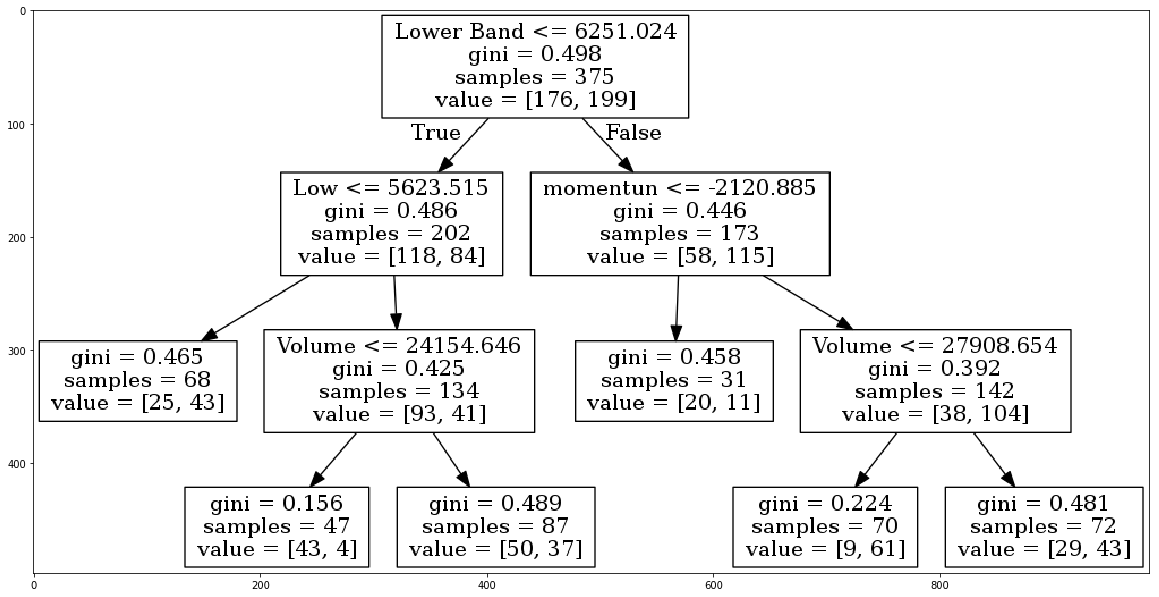

In [29]:
%%time
showTree(dct, features, 'minhaprimeiradct.png')

Para ver o desempenho do algoritmo primeiro testa-se previsões com o dataset de test e em seguida calcula-se o acerto.

In [30]:
from sklearn.metrics import accuracy_score

y_pred = tree.predict(x_test)
score = accuracy_score(y_test, y_pred)*100
print('Score = {}'.format(score))

Score = 63.829787234042556


#### Problemas

Nesse teste obtemos 67% de acerto, que pode ser facilmente melhorado pois cometemos alguns erros nesse teste:

+ 1 Os dados não estavam normalizados
+ 2 Árvores de decisão tem um grande número de impurezas e não são a melhor opção para a aplicação
+ 3 Rodamos o algoritmo com todos os hyperparametros e features default
+ 4 O método de teste usado não é confiável 

#### Soluções para os problemas
+ 1 Normalizar os dados na mesma escala, o scklearn tem algumas técnicas de normalização como StandardScaler e MinMaxScaler
+ 2 Testar algoritmos mais elaborados, existem muitos a disposição como Random Forest e Gradient Boosting
+ 3 Otimizar hiperparametros com técnicas como por exemplo GradientSearch e Bagging 
+ 4 Testar com K-fold

# Pipelines 

Para corrigir alguns erros e testar mais algoritmos com menos exforço usamos pipelines onde se encapsula os algoritmos para que possam ser treinados com maior facilidade.

### Criando pipelines para teste dos modelos

#### Crio 4 pipelines e verifico a acurácia de todos com cross validation com 5 dobras utilizando diferentes combinações de scallers


+ pipeline 1 random forest com standart scaller
+ pipeline 2 random forest com minmaxacaller
+ pipeline 3 suport vector machines com minmaxscaller
+ pipeline 4 gradient boosting com minmaxscaller

In [31]:
# Scallers pra padronizar os dados no momento testarei 2 nos pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Validações e otimizações
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

#pipelines e gridsearch
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#algoritmos
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [32]:
pip_1 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', RandomForestClassifier())
])

pip_1.fit(x_train, y_train)
np.mean(cross_val_score(pip_1, x_train, y_train, cv=5))


0.7704713134186818

In [33]:
pip_2 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', BaggingClassifier(RandomForestClassifier()))
])

pip_2.fit(x_train, y_train)
np.mean(cross_val_score(pip_2, x_train, y_train, cv=5))

0.8078795637743006

In [34]:
pip_3 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', svm.SVC())
])

pip_3.fit(x_train, y_train)
np.mean(cross_val_score(pip_3, x_train, y_train, cv=5))

0.538597439544808

In [35]:
pip_4 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', GradientBoostingClassifier())
])

pip_4.fit(x_train, y_train)
np.mean(cross_val_score(pip_4, x_train, y_train, cv=5))

0.7943669985775249

### Como esperado

Os modelos com melhor resultado foram BaggingClassifier(RandomForestClassifier()) onde combinamos RandomForest com a técnica de Bagging e o algoritmo GradientBoostingClassifier(), que já possui um ótimo histórico e vence muitas competições no Kaggle.

## Automatizando testes

Pipelines são facilmente automatizadas pois podemos criar as pipelines para nosso modelo e em seguida paralelizar o processamento por meio de threads.

Abaixo cria-se 10 pipelines com combinações diferentes de algoritmos.

In [36]:
# random forest - standart
pip_1 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', RandomForestClassifier())
])

# random forest + minmax + bagging
pip_2 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', BaggingClassifier(RandomForestClassifier()))
])

# random forest + standart + bagging
pip_3 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', GradientBoostingClassifier())
])


# gradient + minmax
pip_4 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('clf', GradientBoostingClassifier())
])

#ada boost + standart 
pip_5 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', AdaBoostClassifier())
])

# adaboost minmax + bagging
pip_6 = Pipeline([
    ('scaler',MinMaxScaler()),
    ('clf', BaggingClassifier(AdaBoostClassifier()))
])

pip_7 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', BaggingClassifier(AdaBoostClassifier()))
])

#bagging + voting
pip_8 = Pipeline([
    ('scaler',MinMaxScaler()),
    ('clf',  BaggingClassifier(KNeighborsClassifier()))
])


pip_9 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', KNeighborsClassifier())
])


pip_10 = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', LogisticRegression())
])

### Pool de threads

Cria-se então uma pool de threads onde cada thread executará um pipeline e testará seu modelo. Abaixo os resultados:

In [37]:
results = []
d = {'alg': [], 'result': []}
df = pd.DataFrame(data=d)

import threading
class Threads (threading.Thread):
    
    
    def __init__(self, threadID, pipeline):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.pipeline = pipeline
    
    def run(self):
        self.evalModel()
    
    def evalModel(self):
        self.pipeline.fit(x_train, y_train)
        result = np.mean(cross_val_score(self.pipeline, x_train, y_train, cv=5))
        paramns = self.pipeline.get_params()

        df.loc[-1] = [paramns, result]
        df.index = df.index +1

In [38]:
class Process():
    
    
    def __init__(self):
        self.pipelines = [pip_1, pip_2, pip_3, pip_4, pip_5, pip_6, pip_7, pip_8, pip_9, pip_10]
        self.threads = []

    def startProcess(self):
        self.createThreads()
        self.startThreads()
        self.checkThreads()
        
    def createThreads(self):
        for x in range (0, len(self.pipelines)):
            self.threads.append(Threads(x, self.pipelines[x]))
        
    def startThreads(self):
        for thread in self.threads:
            thread.start()
    
    def checkThreads(self):
        i = True
        while(i):
            if (all(thread.is_alive() == False for thread in self.threads)):
                i = False
            else:
                time.sleep(2)

In [39]:
%%time
from IPython.display import clear_output

pc = Process()
pc.startProcess()
clear_output()

CPU times: user 16.8 s, sys: 1.03 s, total: 17.8 s
Wall time: 18.2 s


#### Abaixo o podium

In [40]:
pd.options.display.max_colwidth = 1000
df = df.sort_values(by=['result'], ascending=False)
df.head(3)

,alg,result
3,"{'memory': None, 'steps': [('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, presort='auto', random_state=None, subsample=1.0, verbose=0, warm_start=False))], 'min_max_scaler': MinMaxScaler(copy=True, feature_range=(0, 1)), 'clf': ([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort='auto', random_state=<mtrand.RandomState object at 0x7f8099...",0.799700
7,"{'memory': None, 'steps': [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1, oob_score=False, random_state=None, verbose=0, warm_start=False))], 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'clf': (DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=1777498707, splitter='best'), DecisionTreeClassifier(class_wei...",0.794436
2,"{'memory': None, 'steps': [('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1, oob_score=False, random_state=None, verbose=0, warm_start=False), bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False, random_state=None, verbose=0, warm_start=False))], 'min_max_scaler': MinMaxScaler(copy=True, feature_range=(0, 1)), 'clf': ((DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0....",0.794401


## 7 Present a solution

# Nosso vencedor é GradientBoostingClassifier, será o algoritmo ultilizado:

In [41]:
df.head(1)['alg']

3    {'memory': None, 'steps': [('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))], 'min_max_scaler': MinMaxScaler(copy=True, feature_range=(0, 1)), 'clf': ([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x7f809

## 6 fine tune your models and combine them into a great solution

Desafio, nessa parte retorne a seleção das features, target e utilize métodos como gridsearch para encontrar a melhor combinação de parâmetros.

# Full test

```
---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
 RESULT 0.6191188448722695
---------------------------------------------------------------------


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
 RESULT 0.7569754411946192
---------------------------------------------------------------------


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])
 RESULT 0.7543097618166111
---------------------------------------------------------------------


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
     ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
 RESULT 0.8084087375046278
---------------------------------------------------------------------

---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
 RESULT 0.8028922621251388
---------------------------------------------------------------------


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])
 RESULT 0.8244817968653585
---------------------------------------------------------------------

---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, ...estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])
 RESULT 0.8247350364062692
---------------------------------------------------------------------

---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('min_max_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_dec...estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])
 RESULT 0.8109273108725162
---------------------------------------------------------------------

---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', BaggingClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])
 RESULT 0.7811595705294335
---------------------------------------------------------------------


---------------------------------------------------------------------
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', BaggingClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])
 RESULT 0.7837492286807356
---------------------------------------------------------------------

Threads terminadas

```

Com base nos testes a pipeline escolhida para a implementação no bot é a seguinte:


 Pipeline(memory=None,
     steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, ...estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])
 RESULT 0.8247350364062692
 
 ***RandomForestClassifier + MinMaxScaler***
 

# BONUS KerasClassifier

In [107]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [108]:
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(17, input_dim=17, kernel_initializer='normal', activation='relu'))
    model.add(Dense(34, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [109]:
%%time
seed = 7
np.random.seed(seed)

estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 53.61% (0.64%)
CPU times: user 44.5 s, sys: 152 ms, total: 44.6 s
Wall time: 44.7 s


Esse resultado informa um modelo underfitado...

## Propagação do erro

Para estimar o erro não podemos esquecer do erro inicial então para saber o erro total multiplica-se a taxa de acerto do lookahead de 0.7 com a taxa de acerto do modelo 0.82, obtendo um acerto total de 57% dos trades.

# 7 Present  a solution -> próximo arquivo